Copyright (c) Microsoft Corporation. All rights reserved.
Licensed under the MIT License.
Modified by Shohei Nagata, 1st April 2021.

# PyTorchの分散学習 (DistributedDataParallel版)
本日のハンズオンでは[CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html)データセットを対象に、PyTorchの`DistributedDataParallel`モジュールを用いてGPUクラスター間で分散学習を行い、PyTorchモデルを学習します。

## 前提条件確認

事前にAzure Machine Learning Python SDKをインストールし、Azure ML `Workspace`を作成してください。  
※Azure Machine Learning Notebook VMを使用している場合は、すべての設定が完了しています。

In [2]:
# Azure ML SDKのバージョン確認
import azureml.core

print("SDK version:", azureml.core.VERSION)

SDK version: 1.25.0


## ワークスペースの設定
Azure ML ワークスペースによってAzure MLで使用するアセット類 (データ、スクリプト、出力、等々)を管理していきます。
![](https://docs.microsoft.com/ja-jp/azure/machine-learning/media/concept-azure-machine-learning-architecture/architecture.svg)

前提条件のステップで作成した既存のワークスペースから、[Workspace](https://docs.microsoft.com/azure/machine-learning/service/concept-azure-machine-learning-architecture#workspace)オブジェクトを初期化します。`Workspace.from_config()` は、`config.json` に格納された詳細情報から、ワークスペース・オブジェクトを作成します。   

事前にAzure ML Studioから構成ファイル (config.json)をダウンロードし、本スクリプトと同一階層に置きます。  

初回実行時は認証を行う必要があるため、実行結果部分の指示に従って https://microsoft.com/devicelogin にアクセスし、認証コードを入力します。

In [3]:
from azureml.core.workspace import Workspace

ws = Workspace.from_config()
print('Workspace name: ' + ws.name, 
      'Azure region: ' + ws.location, 
      'Subscription id: ' + ws.subscription_id, 
      'Resource group: ' + ws.resource_group, sep='\n')

Workspace name: ml-lab
Azure region: westus2
Subscription id: f57ce3c6-5c6f-4f1e-8cba-b782d8974590
Resource group: rg-aml


## 計算環境の準備

モデルをトレーニングするためには、[コンピューティング先](hhttps://docs.microsoft.com/ja-jp/azure/machine-learning/concept-azure-machine-learning-architecture#computes)を作成する必要があります。このノートブックでは、コンピューティング クラスターをリモートトレーニング用のコンピュートリソースとして使用します。  
具体的には，以下のコードで，`STANDARD_NC6`のGPUクラスターを作成し，`0`から`4`のノードにオートスケールします。

**コンピューティングクラスターの作成には約5分かかります。** 同一名称のものがワークスペースにある場合、下記コードは作成プロセスをスキップします。

他のAzureサービスと同様に、Azure Machine Learningサービスに関連する特定のリソース（コンピューティング インスタンス、コンピューティング クラスターなど）には制限があります。  
参考：[Azure Machine Learning を使用するリソースのクォータの管理と引き上げ](https://docs.microsoft.com/ja-jp/azure/machine-learning/how-to-manage-quotas)、
[申請手順](https://docs.microsoft.com/ja-jp/azure/azure-portal/supportability/regional-quota-requests#request-a-quota-increase-by-region-from-help--support)


In [4]:
from azureml.core.compute import ComputeTarget, AmlCompute
from azureml.core.compute_target import ComputeTargetException

# choose a name for your cluster
cluster_name = 'gpu-cluster'

try:
    compute_target = ComputeTarget(workspace=ws, name=cluster_name)
    print('Found existing compute target.')
except ComputeTargetException:
    print('Creating a new compute target...')
    compute_config = AmlCompute.provisioning_configuration(vm_size='STANDARD_NC6', # 使用するVMインスタンスを指定します
                                                           max_nodes=4)

    # create the cluster
    compute_target = ComputeTarget.create(ws, cluster_name, compute_config)

    compute_target.wait_for_completion(show_output=True)

# use get_status() to get a detailed status for the current AmlCompute. 
print(compute_target.get_status().serialize())

Found existing compute target.
{'currentNodeCount': 0, 'targetNodeCount': 0, 'nodeStateCounts': {'preparingNodeCount': 0, 'runningNodeCount': 0, 'idleNodeCount': 0, 'unusableNodeCount': 0, 'leavingNodeCount': 0, 'preemptedNodeCount': 0}, 'allocationState': 'Steady', 'allocationStateTransitionTime': '2021-03-23T03:45:29.543000+00:00', 'errors': None, 'creationTime': '2021-03-22T09:03:01.130767+00:00', 'modifiedTime': '2021-03-22T09:03:16.578884+00:00', 'provisioningState': 'Succeeded', 'provisioningStateTransitionTime': None, 'scaleSettings': {'minNodeCount': 0, 'maxNodeCount': 4, 'nodeIdleTimeBeforeScaleDown': 'PT120S'}, 'vmPriority': 'Dedicated', 'vmSize': 'STANDARD_NC6'}


## データセットの準備

学習に使用するデータセットを準備します。まず、cs.toronto.eduのサイトから公開されているCIFAR-10データセットをダウンロードして抽出し、Azure ML FileDatasetを作成して学習に使用します。

### CIFAR-10 データのダウンロードと解凍

In [5]:
import urllib
import tarfile
import os

url = 'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz'
filename = 'cifar-10-python.tar.gz'
data_root = 'cifar-10'
filepath = os.path.join(data_root, filename)

if not os.path.isdir(data_root):
    os.makedirs(data_root, exist_ok=True)
    urllib.request.urlretrieve(url, filepath)
    with tarfile.open(filepath, "r:gz") as tar:
        tar.extractall(path=data_root)
    os.remove(filepath)  # delete tar.gz file after extraction

### Azure MLデータセットの作成

`upload_directory`メソッドは、データストアにデータをアップロードし、そこからFileDatasetを作成します。このチュートリアルでは、ワークスペースのデフォルトのデータストアを使用します。

In [6]:
from azureml.core import Dataset

datastore = ws.get_default_datastore()
dataset = Dataset.File.upload_directory(
    src_dir=data_root, target=(datastore, data_root)
)

Method upload_directory: This is an experimental method, and may change at any time.<br/>For more information, see https://aka.ms/azuremlexperimental.
Validating arguments.
Arguments validated.
Uploading file to cifar-10
Uploading an estimated of 8 files
Target already exists. Skipping upload for cifar-10/cifar-10-batches-py/data_batch_5
Target already exists. Skipping upload for cifar-10/cifar-10-batches-py/batches.meta
Target already exists. Skipping upload for cifar-10/cifar-10-batches-py/test_batch
Target already exists. Skipping upload for cifar-10/cifar-10-batches-py/data_batch_4
Target already exists. Skipping upload for cifar-10/cifar-10-batches-py/data_batch_3
Target already exists. Skipping upload for cifar-10/cifar-10-batches-py/data_batch_1
Target already exists. Skipping upload for cifar-10/cifar-10-batches-py/readme.html
Target already exists. Skipping upload for cifar-10/cifar-10-batches-py/data_batch_2
Uploaded 0 files
Creating new dataset


## リモートでのモデル学習 
リモート (Azure ML上の)計算環境が準備できたので、分散学習ジョブを実行してみましょう。

### プロジェクトディレクトリの作成
ローカルマシンからリモートリソースにアクセスするために必要なコードをすべて格納するディレクトリを作成します。このディレクトリには、トレーニングスクリプトと、トレーニングスクリプトが依存する追加ファイルが含まれます。

In [7]:
project_folder = './pytorch-distr'
os.makedirs(project_folder, exist_ok=True)

### トレーニングスクリプトの準備
ここでは、トレーニング用のスクリプトを作成します。このチュートリアルでは、CIFAR-10の分散学習用のスクリプトを`train.py`で用意しています。実際には、カスタムのPyTorchトレーニングスクリプトをそのまま使用して、コードを変更することなくAzure MLで実行することが可能です。

トレーニングスクリプト `train.py`をプロジェクトディレクトリ内へコピーします。

In [38]:
import shutil

shutil.copy('train.py', project_folder)

'./pytorch-distr/train.py'

### 実験の作成
[実験 (Experiment)](https://docs.microsoft.com/azure/machine-learning/service/concept-azure-machine-learning-architecture#experiment)を作成して、この分散PyTorchチュートリアルのワークスペースでのすべての実行を追跡します。

In [9]:
from azureml.core import Experiment

experiment_name = 'pytorch-distr'
experiment = Experiment(ws, name=experiment_name)

### 環境の作成

Azure MLではいくつかの[キュレートされた実行環境](https://docs.microsoft.com/ja-jp/azure/machine-learning/how-to-use-environments#use-a-curated-environment)が用意されています。
今回はPyTorch 1.6 GPU環境を使用します。こちらのキュレートされた環境には今回のトレーニングスクリプトで必要なtorch, torchvisionも含まれています。

参考：[キュレーションされた環境一覧](https://docs.microsoft.com/ja-jp/azure/machine-learning/resource-curated-environments)

In [5]:
from azureml.core import Environment

pytorch_env = Environment.get(ws, name='AzureML-PyTorch-1.6-GPU')

In [64]:
# 中身の確認
print(pytorch_env.python.conda_dependencies.serialize_to_string())

channels:
- conda-forge
dependencies:
- python=3.6.2
- pip:
  - azureml-core==1.18.0.post1
  - azureml-defaults==1.18.0
  - azureml-telemetry==1.18.0
  - azureml-train-restclients-hyperdrive==1.18.0
  - azureml-train-core==1.18.0
  - cmake==3.18.2
  - torch==1.6.0
  - torchvision==0.5.0
  - mkl==2018.0.3
  - horovod==0.20.0
  - tensorboard==1.14.0
  - future==0.17.1
name: azureml_9d2a515d5c77954f2d0562cc5eb8a1fc



### トレーニングジョブの設定

Azure MLで分散PyTorchジョブを開始するには、次の2つの方法があります。

1. プロセスごとの起動 - 実行するワーカープロセスの総数を指定します (通常、GPUごとに1つ)。
Azure ML によって各プロセスの起動が処理されます。
2. [torch.distributed.launch](https://pytorch.org/docs/stable/distributed.html#launch-utility) を使ったノード単位の起動 - 各ノードで実行したい「torch.distributed.launch」コマンドを指定します。Torch 起動ユーティリティによって、各ノードのワーカー プロセスの起動が処理されます。

これらの起動オプションには、基本的な違いはありません。
詳細は[ドキュメント](https://docs.microsoft.com/ja-jp/azure/machine-learning/how-to-train-pytorch#distributeddataparallel)を参照してください。

両方のオプションを以下に示します。

#### プロセスごとの起動

トレーニングスクリプトを実行するための各プロセスの起動をAzure MLが処理して分散 PyTorch ジョブを実行するには、次の操作を行います。

1. トレーニング スクリプトと引数を指定します。
2. `PyTorchConfiguration` を作成し、`process_count` と `node_count` を指定します。 `process_count` は、ジョブに対して実行するプロセスの合計数に対応しています。 これは通常、ノードあたりの GPU の数にノード数を掛けた値と同じにします。 `process_count` を指定しないと、Azure ML では、既定でノードごとに 1 つのプロセスが起動されます。

In [43]:
from azureml.core import ScriptRunConfig
from azureml.core.runconfig import PyTorchConfiguration

# create distributed config
distr_config = PyTorchConfiguration(process_count=2, node_count=2)

# create args
args = ["--data-dir", dataset.as_download(), "--epochs", 25]

# create job config
src = ScriptRunConfig(source_directory=project_folder,
                      script='train.py',
                      arguments=args,
                      compute_target=compute_target,
                      environment=pytorch_env,
                      distributed_job_config=distr_config)

#### `torch.distributed.launch` によるノード毎の起動

もし、PyTorchが提供する起動ユーティリティー `torch.distributed.launch` を使って、各ノードのワーカープロセスの起動を処理したい場合は、以下のようにしても構いません。

1. ScriptRunConfigの`command`パラメータにlaunchコマンドを指定します。PyTorch のジョブの場合、Azure ML は各ノードに環境変数 `MASTER_ADDR`, `MASTER_PORT`, `NODE_RANK` を設定しますので、コマンドの中でこれらの環境変数を参照すればよいのです。GPU数が1以上のSKUを使用している場合は、`--nproc_per_node`の引数を適宜調整してください。

2. `PyTorchConfiguration`を作成し、`node_count`を指定します。デフォルトでは、Azure MLはノードごとに1つのプロセスを起動して、指定した`コマンド`を実行しますので、`process_count`を指定する必要はありません。

以下のコードをコメントアウト解除して、この方法でジョブを設定してください。

In [ ]:
'''
from azureml.core import ScriptRunConfig
from azureml.core.runconfig import PyTorchConfiguration

# create distributed config
distr_config = PyTorchConfiguration(node_count=2)

# define command
launch_cmd = ["python -m torch.distributed.launch --nproc_per_node 1 --nnodes 2 " \
    "--node_rank $NODE_RANK --master_addr $MASTER_ADDR --master_port $MASTER_PORT --use_env " \
    "train.py --data-dir", dataset.as_download(), "--epochs 25"]

# create job config
src = ScriptRunConfig(source_directory=project_folder,
                      command=launch_cmd,
                      compute_target=compute_target,
                      environment=pytorch_env,
                      distributed_job_config=distr_config)
'''

### トレーニングジョブの実行 (送信)
前セルの`ScriptRunConfig`で設定した条件に基づいて実験を実行 (送信)します。
Run your experiment by submitting your `ScriptRunConfig` object. Note that this call is asynchronous.

In [44]:
run = experiment.submit(src)
print(run)

Run(Experiment: pytorch-distr,
Id: pytorch-distr_1617070361_76d0aa71,
Type: azureml.scriptrun,
Status: Preparing)


### モニタリング
Jupyterウィジェットを使って実行の進捗状況を監視することができます。実行のサブミッションと同様に、ウィジェットは非同期で、ジョブが完了するまで10～15秒ごとに自動で更新されます。ウィジェットでは、Azure MLの実行に記録した損失指標が自動的に表示・可視化されます。

※VSCode上で実行する場合、テーマ設定 (背景色)によってはAzure MLウィジェットが見えにくくなる可能性があります。その場合はLightテーマの使用をお勧めします。

In [114]:
from azureml.widgets import RunDetails

RunDetails(run).show()

_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': True, 'log_level': 'INFO', 's…

また、スクリプトのトレーニングが完了するまでノートブックの実行をブロックしてから、さらにそれ以降のコードを実行していく形にもできます。

In [46]:
run.wait_for_completion(show_output=True) # this provides a verbose log

RunId: pytorch-distr_1617070361_76d0aa71
Web View: https://ml.azure.com/runs/pytorch-distr_1617070361_76d0aa71?wsid=/subscriptions/f57ce3c6-5c6f-4f1e-8cba-b782d8974590/resourcegroups/rg-aml/workspaces/ml-lab&tid=72f988bf-86f1-41af-91ab-2d7cd011db47

Streaming azureml-logs/65_job_prep-tvmps_70b6890346015bc915416859fb4c2b96e3f18624ff430d2fb8e27bc7358d61aa_d.txt

[2021-03-30T02:17:20.271641] Entering job preparation.
[2021-03-30T02:17:20.783806] Starting job preparation.
[2021-03-30T02:17:20.783844] Extracting the control code.
[2021-03-30T02:17:20.790138] fetching and extracting the control code on master node.
[2021-03-30T02:17:20.790163] Starting extract_project.
[2021-03-30T02:17:20.790193] Starting to extract zip file.
[2021-03-30T02:17:21.438495] Finished extracting zip file.
[2021-03-30T02:17:21.606756] Using urllib.request Python 3.0 or later
[2021-03-30T02:17:21.606814] Start fetching snapshots.
[2021-03-30T02:17:21.606855] Start fetching snapshot.
[2021-03-30T02:17:21.606871] Re

{'runId': 'pytorch-distr_1617070361_76d0aa71',
 'target': 'gpu-cluster',
 'status': 'Completed',
 'startTimeUtc': '2021-03-30T02:16:57.267905Z',
 'endTimeUtc': '2021-03-30T02:29:23.967689Z',
 'properties': {'_azureml.ComputeTargetType': 'amlcompute',
  'ContentSnapshotId': '045927a0-df79-455a-9e73-27de45de22d1',
  'azureml.git.repository_uri': 'git@github.com:shohei1029/azureml_distributed-pytorch.git',
  'mlflow.source.git.repoURL': 'git@github.com:shohei1029/azureml_distributed-pytorch.git',
  'azureml.git.branch': 'main',
  'mlflow.source.git.branch': 'main',
  'azureml.git.commit': '26e588cedaeed49e79d8b52b98e6c69d45fe1b8c',
  'mlflow.source.git.commit': '26e588cedaeed49e79d8b52b98e6c69d45fe1b8c',
  'azureml.git.dirty': 'False',
  'ProcessInfoFile': 'azureml-logs/process_info.json',
  'ProcessStatusFile': 'azureml-logs/process_status.json'},
 'inputDatasets': [{'dataset': {'id': '5552c1f0-d54d-4c12-9dea-c3c6d08c5c4f'}, 'consumptionDetails': {'type': 'RunInput', 'inputName': 'input_

## モデルの登録


In [47]:
#実行に関係しているファイル一覧の表示
for i in run.get_file_names():
    print(i)

azureml-logs/55_azureml-execution-tvmps_70b6890346015bc915416859fb4c2b96e3f18624ff430d2fb8e27bc7358d61aa_d.txt
azureml-logs/55_azureml-execution-tvmps_cd1cec81acfb1f5ae9cacf052331a2ab34bbc547f3c9631f2ab255b657b4924c_d.txt
azureml-logs/65_job_prep-tvmps_70b6890346015bc915416859fb4c2b96e3f18624ff430d2fb8e27bc7358d61aa_d.txt
azureml-logs/65_job_prep-tvmps_cd1cec81acfb1f5ae9cacf052331a2ab34bbc547f3c9631f2ab255b657b4924c_d.txt
azureml-logs/70_driver_log_0.txt
azureml-logs/70_driver_log_1.txt
azureml-logs/75_job_post-tvmps_70b6890346015bc915416859fb4c2b96e3f18624ff430d2fb8e27bc7358d61aa_d.txt
azureml-logs/75_job_post-tvmps_cd1cec81acfb1f5ae9cacf052331a2ab34bbc547f3c9631f2ab255b657b4924c_d.txt
azureml-logs/process_info.json
azureml-logs/process_status.json
logs/azureml/0_110_azureml.log
logs/azureml/1_89_azureml.log
logs/azureml/dataprep/backgroundProcess.log
logs/azureml/dataprep/backgroundProcess_Telemetry.log
logs/azureml/job_prep_azureml.log
logs/azureml/job_release_azureml.log
logs/azure

In [48]:
model = run.register_model(model_name = 'pytorch-distr', model_path = 'outputs/cifar_net.pt')
print(model.name, model.id, model.version, sep = '\t')

pytorch-distr	pytorch-distr:3	3


## モデルデプロイ
Azure Container Instances (ACI) にモデルをWebサービスとしてモデルをデプロイしていきます。  
参考：[Azure Container Instances とは](https://docs.microsoft.com/ja-jp/azure/container-instances/container-instances-overview)

### スコアリングスクリプトの作成
Web サービスの呼び出しに使用される score.py というスコアリング スクリプトを作成してモデルの使用方法を示します。
スコアリング スクリプトには、2 つの必要な関数を含める必要があります。
- `init()` 関数。通常、グローバル オブジェクトにモデルを読み込みます。 この関数は、Docker コンテナーを開始するときに 1 回だけ実行されます。
- `run(input_data)` 関数。モデルを使用して、入力データに基づく値を予測します。 実行に対する入力と出力は、通常、JSON を使用してシリアル化およびシリアル化解除が実行されますが、その他の形式もサポートされています。

In [53]:
%%writefile score.py
import os
import json
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms

from azureml.core.model import Model

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3) # in_channels, out_channels, kernel_size, 
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.conv3 = nn.Conv2d(64, 128, 3)
        self.fc1 = nn.Linear(128 * 6 * 6, 120)
        self.dropout = nn.Dropout(p=0.2)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 6 * 6)
        x = self.dropout(F.relu(self.fc1(x)))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


def init():
    global model
    # AZUREML_MODEL_DIR is an environment variable created during deployment.
    # It is the path to the model folder (./azureml-models/$MODEL_NAME/$VERSION)
    # For multiple models, it points to the folder containing all deployed models (./azureml-models)
    model_path = os.path.join(os.getenv('AZUREML_MODEL_DIR'), 'cifar_net.pt')
    model = Net()    
    model.load_state_dict(torch.load(model_path,map_location=torch.device('cpu')))
    model.eval()

def run(input_data):
    input_data = torch.tensor(json.loads(input_data)['data'])

    # get prediction
    with torch.no_grad():
        input_data = input_data.unsqueeze(0) # add batch dimension
        output = model(input_data) 
        classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
        softmax = nn.Softmax(dim=1)
        pred_probs = softmax(output).numpy()[0]
        index = torch.argmax(output, 1) 

    result = {"label": classes[index], "probability": str(pred_probs[index])}
    return result

Overwriting score.py


### ACIコンテナへのデプロイ
デプロイの構成ファイルを作成し、ACI コンテナーに必要な CPU 数と RAM ギガバイト数を指定します。 実際のモデルにもよりますが、通常、多くのモデルには既定値の 1 コアと 1 ギガバイトの RAM で十分です。 後でもっと必要になった場合は、イメージを再作成し、サービスをデプロイし直す必要があります。
※今回はデプロイ先の実行環境にはトレーニング時と同一の環境を使用しています。

In [6]:
%%time
from azureml.core.webservice import AciWebservice
from azureml.core.model import InferenceConfig
from azureml.core.webservice import Webservice
from azureml.core.model import Model

#推論スクリプト・環境の指定
inference_config = InferenceConfig(entry_script="score.py", environment=pytorch_env) # 学習時と同じ環境を使用

#デプロイの構成設定
aciconfig = AciWebservice.deploy_configuration(cpu_cores=1, 
                                               memory_gb=1, 
                                               tags={'data': 'cifar-10',  'model':'pytorch-distr', 'framework':'pytorch'},
                                               description='Classify daily objects from the cifar-10 dataset using PyTorch')

model = Model(ws, 'pytorch-distr')

service = Model.deploy(workspace=ws, 
                           name='aci-cifar10', 
                           models=[model], 
                           inference_config=inference_config, 
                           deployment_config=aciconfig,
                           overwrite=True)

service.wait_for_deployment(show_output=True)
print(service.state)

Tips: You can try get_logs(): https://aka.ms/debugimage#dockerlog or local deployment: https://aka.ms/debugimage#debug-locally to debug if deployment takes longer than 10 minutes.
Running
2021-04-01 14:28:35+09:00 Creating Container Registry if not exists.
2021-04-01 14:28:35+09:00 Registering the environment.
2021-04-01 14:28:36+09:00 Use the existing image.
2021-04-01 14:28:37+09:00 Generating deployment configuration.
2021-04-01 14:28:37+09:00 Submitting deployment to compute.
2021-04-01 14:28:41+09:00 Checking the status of deployment aci-cifar10..
2021-04-01 14:43:24+09:00 Checking the status of inference endpoint aci-cifar10.
Succeeded
ACI service creation operation finished, operation "Succeeded"
Healthy
CPU times: user 942 ms, sys: 56 ms, total: 998 ms
Wall time: 14min 59s


In [12]:
# # デプロイ中に問題が発生した場合にログ取得
# service.get_logs()

In [13]:
# # 再デプロイ前に既存のACIサービスを削除
# service.delete()

## Webサービスのテスト
最後に、デプロイしたWebサービスをテストしてみましょう。ACIにホストされているWebサービスにJSON文字列としてデータを送信し、SDKのrun APIを使ってサービスを呼び出してみます。ここでは、検証データから画像を取り出して予測を行います。


In [1]:
# # 既存のACIWebサービスを取得する場合. serviceを定義する。
# from azureml.core.workspace import Workspace
# from azureml.core.webservice import AciWebservice
# ws = Workspace.from_config()
# service = AciWebservice(workspace=ws, name='aci-cifar10')

Files already downloaded and verified
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


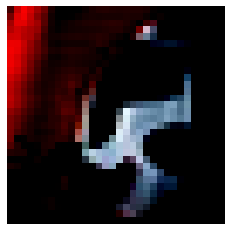

In [9]:
# CIFAR-10 データセット内のテスト画像を用いて推論を行う
import json
import matplotlib.pyplot as plt
from torchvision import transforms
from torchvision.datasets import CIFAR10

transform = transforms.Compose([
    transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
test_dataset = CIFAR10(root="cifar-10", train=False, download=True, transform=transform)
image_tensor, target_class = test_dataset.__getitem__(6) #数字変える
image_np = image_tensor.to('cpu').detach().numpy()
input_data = image_np

# plot image
plt.axis('off')
plt.imshow(image_tensor.to('cpu').detach().transpose(0,2).numpy()) 
plt.show()

In [10]:
# ACIへ送信して推論実行
result = service.run(input_data=json.dumps({'data': input_data.tolist()}))
print(result)

{'label': 'cat', 'probability': '0.87184215'}


## クリーンアップ
最後に、デプロイされたWebサービスを削除します。

In [ ]:
service.delete()